In [1]:
import sys
import pandas as pd
import numpy as np

# Define a random seed for reproducibility
seed = 0
np.random.seed(seed)

import sklearn
import xgboost
import keras
import tensorflow as tf

import os
import pickle


print('Python: {}'.format(sys.version))
print('Pandas: {}'.format(pd.__version__))
print('Numpy: {}'.format(np.__version__))
print('Sklearn: {}'.format(sklearn.__version__))
print('XGBoost: {}'.format(xgboost.__version__))
print('Keras: {}'.format(keras.__version__))

Using TensorFlow backend.


Python: 3.6.10 |Anaconda, Inc.| (default, May  7 2020, 19:46:08) [MSC v.1916 64 bit (AMD64)]
Pandas: 1.0.3
Numpy: 1.18.1
Sklearn: 0.22.1
XGBoost: 1.1.1
Keras: 2.3.1


In [2]:
def load_train_and_test(path):

    """Loads training features, training labels, testing features, and testing features
    Parameters:
        path (str) -- a single directory path containing all four datasets
    """

    train_features = pd.read_csv(path + 'train_features.csv', index_col=0)
    train_labels = pd.read_csv(path + 'train_labels.csv', index_col=0)
    test_features = pd.read_csv(path + 'test_features.csv', index_col=0)
    test_labels = pd.read_csv(path + 'test_labels.csv', index_col=0)

    return train_features, train_labels.values.ravel(), test_features, test_labels.values.ravel()

X_train, Y_train, X_test, Y_test = load_train_and_test('../data/split/')

In [3]:
from sklearn.metrics import roc_auc_score

def permutation_importance(X, y, model): 
    
    """ Add random permutations to each variable in training data to assess variable importance """
    
    perm = {}
    y_true = model.predict_proba(X)[:,1]
    baseline= roc_auc_score(y, y_true)
    
    print('Baseline ROC AUC score: {}'.format(baseline))

    for cols in X.columns:
        new_df = X.copy()
        values = new_df.loc[:,cols]
        new_df.loc[:,cols] = np.random.permutation(values)
        y_true = model.predict_proba(new_df)[:,1]
        perm[cols] = roc_auc_score(y, y_true) - baseline
        
    return perm

In [4]:
# load all optimized models from the models folder

dirName = '../models/'

fileList = list()
dirList = list()

for (dirpath, dirnames, filenames) in os. walk(dirName):
    for file in filenames:
        if '.sav' in file:
            fileList.append(os.path. join(dirpath, file))

modelList = list()

for file in fileList:
    model = pickle.load(open(file, 'rb'))
    modelList.append(model)

In [5]:
# run permutation analysis for each variable and each model

permutations = []

for i,model in enumerate(modelList):
    perms = permutation_importance(X_train.copy(), Y_train.copy(), model)
    permutations.append(perms)
    
scores = pd.DataFrame(permutations, index = [file.split('/')[-1].rstrip('.sav') for file in fileList])
scores

Baseline ROC AUC score: 0.9826011460322974
Baseline ROC AUC score: 0.8775134571974301
Baseline ROC AUC score: 0.9440701510678937
Baseline ROC AUC score: 0.9679805521791979
Baseline ROC AUC score: 0.9818371245007814
Baseline ROC AUC score: 0.9572495224865429
Baseline ROC AUC score: 0.9805174509463449
Baseline ROC AUC score: 0.9846327487411008


,Gender_M,StereoInjury_Yes,StereoScan_Yes,PitTumorType_1,PitTumorType_1_5,PitTumorType_2,PitTumorType_2_3,PitTumorType_2_5,PitTumorType_3,PitTumorType_3_5,...,AnyPostopHormone_Yes,RoomTime,Age,BMI,SympVisual,SympIncidental,SympApoplexy,SympEndocrinopathy,SympHeadache,SympFailureMedMgmt
AdaBoost,-0.002587,0.000000,0.000000,-2.448342e-03,0.0,-0.001771,0.000000,0.0,0.000000,0.000000,...,0.000000,-0.006286,-0.015888,-0.013579,0.0,0.0,0.0,0.0,0.0,0.0
DecisionTree,0.000000,0.000000,0.000000,0.000000e+00,0.0,0.000000,0.000000,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
GradientBoosting,0.000000,0.000000,0.001059,0.000000e+00,0.0,0.000260,0.000000,0.0,0.000000,0.000000,...,0.000000,-0.001389,0.000000,-0.003525,0.0,0.0,0.0,0.0,0.0,0.0
LogisticRegression,-0.003733,0.000000,0.000000,0.000000e+00,0.0,-0.001389,0.000000,0.0,-0.000208,0.000000,...,0.000000,0.000695,0.000382,-0.000695,0.0,0.0,0.0,0.0,0.0,0.0
MLP,-0.000260,-0.001389,-0.000799,-1.111304e-03,0.0,-0.004098,-0.000104,0.0,-0.000382,-0.000035,...,-0.001111,-0.006911,-0.011773,-0.005279,0.0,0.0,0.0,0.0,0.0,0.0
RandomForest,0.000087,0.000000,-0.000069,-1.110223e-16,0.0,0.000000,0.000000,0.0,-0.000625,0.000000,...,-0.001858,-0.001511,-0.001268,-0.004081,0.0,0.0,0.0,0.0,0.0,0.0
SVC,-0.005765,-0.000035,-0.000660,-1.632228e-03,0.0,0.000347,-0.000035,0.0,-0.001962,0.000000,...,-0.000486,-0.004272,-0.007953,-0.001650,0.0,0.0,0.0,0.0,0.0,0.0
XGBoost,-0.002622,0.000000,-0.003317,-5.747526e-03,0.0,0.000000,0.000000,0.0,0.000000,0.000000,...,-0.001945,-0.003334,-0.030109,-0.003612,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
# print total permutation values for all optimized models

# Note - more negative values mean the algorithm was impacted significantly by permutations of this column (ie, this column is an important variable)
# Note - positive values may indicate the algorithm's performance is decreased by inclusion of this variable. 

totals = scores.mean(axis=0)
totals.sort_values()

GTR_No                 -0.172328
Recurrence_Yes         -0.031520
AnyPreopHormone_0      -0.010178
Age                    -0.008326
Recurrence_Unknown     -0.006229
GTR_Yes                -0.004200
BMI                    -0.004052
AnyPostopHormone_0     -0.003503
RoomTime               -0.002876
Recurrence_No          -0.002850
Gender_M               -0.001860
AnyPreopHormone_No     -0.001771
PitTumorType_1         -0.001367
GTR_Unknown            -0.001194
AnyPreopHormone_Yes    -0.000851
PitTumorType_2         -0.000831
AnyPostopHormone_Yes   -0.000675
StereoScan_Yes         -0.000473
PitTumorType_3         -0.000397
FatOrFascia_Yes        -0.000341
Complication_Yes       -0.000291
CSFDiversion_1         -0.000287
CSFDiversion_2         -0.000287
SizeCategory_Macro     -0.000269
Endoscope_Unknown      -0.000252
Endoscope_No           -0.000234
StereoInjury_Yes       -0.000178
FatOrFascia_No         -0.000161
PitTumorType_4         -0.000161
AnyPostopHormone_No    -0.000113
ReturntoOR

In [7]:
# Print top 10 most important variables
totals.sort_values()[:10]

GTR_No               -0.172328
Recurrence_Yes       -0.031520
AnyPreopHormone_0    -0.010178
Age                  -0.008326
Recurrence_Unknown   -0.006229
GTR_Yes              -0.004200
BMI                  -0.004052
AnyPostopHormone_0   -0.003503
RoomTime             -0.002876
Recurrence_No        -0.002850
dtype: float64

In [8]:
data = totals.sort_values(ascending=False) * -1

In [9]:
import matplotlib.pyplot as plt

def plot_bar_score(scores, tree=True, offset=0.002, save=False):
    
    pos = np.arange(len(scores))

    plt.figure(figsize=(10,14))
    rects = plt.barh(pos, scores,
                     align='center',
                     height = 0.9,
                     tick_label = scores.keys(),
                     alpha = 0.5
                    )
    
    for rect in rects:
        plt.text(rect.get_width() + offset, rect.get_y(), round(rect.get_width(),3), ha='center', va='bottom')
        
    if tree:
        plt.title("Average Impurity-Based Feature Importance for Tree Algorithms")
    else:
        plt.title("Feature Importance: Average Decrease in AUC Score in Permutation Analysis")
        
    plt.xlim(np.min(scores) - offset, np.max(scores) + offset*2)
    
    #plt.tight_layout()
    
    if save:
        plt.savefig('../reports/figures/{}_bar_graph.png'.format('impurity_features'))
    plt.show

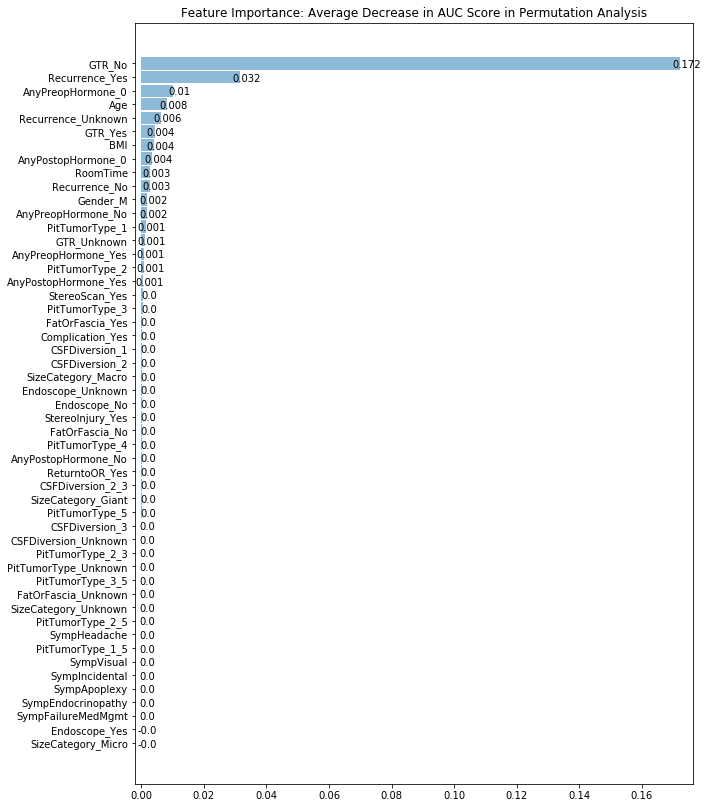

In [10]:
plot_bar_score(data, tree=False, save=True)

In [197]:
# using impurity-based feature importance from tree based approachs
importance = pd.DataFrame(columns=X_train.columns)
stds = pd.DataFrame(columns=X_train.columns)

i=0
for model in modelList:
     
    if hasattr(model, 'feature_importances_'):
        importance.loc[i] = model.feature_importances_
        i += 1

In [198]:
totals = importance.mean(axis=0).sort_values(ascending=True)

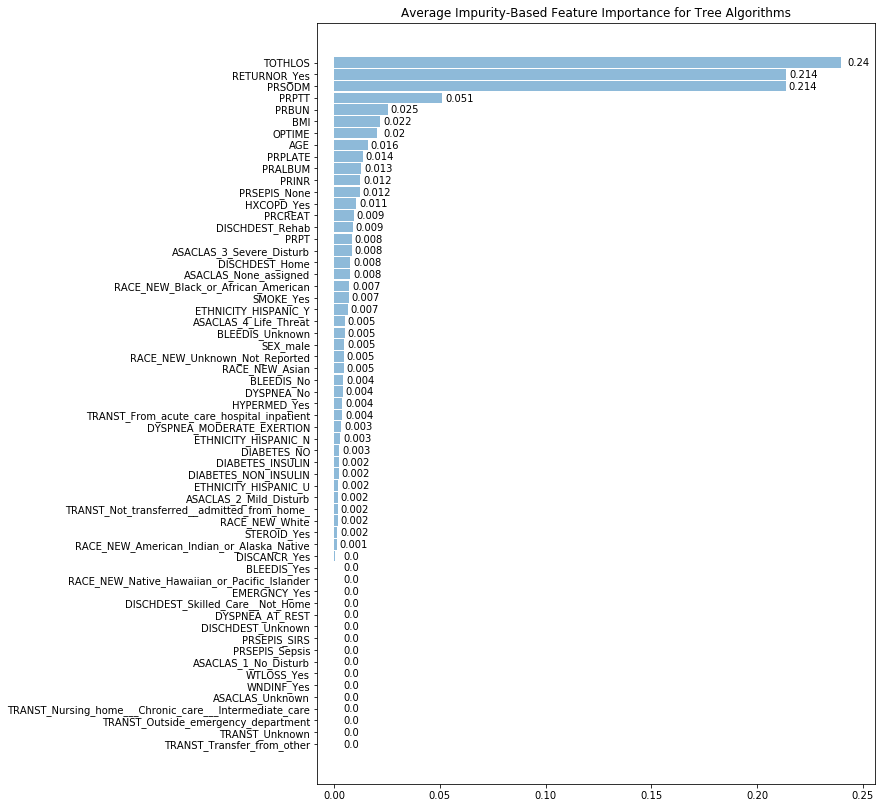

In [200]:
plot_bar_score(totals, offset=0.008, save=True)